In [2]:
import os
import time
import numpy as np
import cv2
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf

In [3]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

BATCH_SIZE = 128
LATENT_DIMENSION = 128 
EPOCHS = 30

In [4]:
def print_subfolders(directory):
    for root, dirs, files in os.walk(directory):
        for name in dirs:
            print(os.path.join(root, name))

print_subfolders("dataset/archive/data")

dataset/archive/data\data


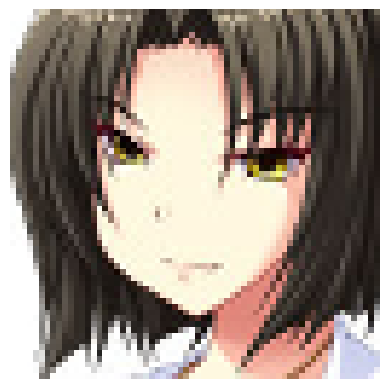

In [5]:
def plot_image_from_path(image_path):
  
    img = Image.open(image_path)

    
    plt.imshow(img)
    plt.axis('off') 
    plt.show()

plot_image_from_path(r'dataset/archive/data/9999.png')

In [6]:
pathToImagesList = glob(r'dataset/archive/data/*')


def removeBadExtensions(pathToImagesList):
    Images = []
    for i in pathToImagesList:
        imageExtension = i.split(".")[-1]
        if imageExtension in ["png", "jpg"]:
            Images.append(i)
    return Images


pathToImagesList = removeBadExtensions(pathToImagesList )

BUFFER_SIZE = len(pathToImagesList)

print("Length:", BUFFER_SIZE)

for i in pathToImagesList:
    imageExtension = i.split(".")[-1]
    if ((imageExtension not in ['png', 'jpg'])):
        print("Bad Extension In", i)
        break

Length: 21551


In [7]:
def loadImage(pathToImage: tf.Tensor):
   
    image_binary = tf.io.read_file(pathToImage)
    
    
    image = tf.io.decode_image(image_binary, channels=IMAGE_CHANNEL, expand_animations=False)

   
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])


    image = tf.cast(image, tf.float32)

 
    image = (image - 127.5) / 127.5

    return image

In [8]:
def tensorFlowDataset(pathToImagesList, batchSize):
    
   
    dataset = tf.data.Dataset.from_tensor_slices(pathToImagesList)

   
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(loadImage, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.batch(batchSize)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [9]:
dataset = tensorFlowDataset(pathToImagesList, BATCH_SIZE)

print(len(dataset))

for index, singleData in enumerate(dataset):
    print(index+1,":", singleData.shape)
    if index == 14:
        break

169
1 : (128, 64, 64, 3)
2 : (128, 64, 64, 3)
3 : (128, 64, 64, 3)
4 : (128, 64, 64, 3)
5 : (128, 64, 64, 3)
6 : (128, 64, 64, 3)
7 : (128, 64, 64, 3)
8 : (128, 64, 64, 3)
9 : (128, 64, 64, 3)
10 : (128, 64, 64, 3)
11 : (128, 64, 64, 3)
12 : (128, 64, 64, 3)
13 : (128, 64, 64, 3)
14 : (128, 64, 64, 3)
15 : (128, 64, 64, 3)


In [10]:
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

print(WEIGHT_INIT.get_config())

{'mean': 0.0, 'stddev': 0.02, 'seed': None}


In [11]:
def transposeLayer(inputs, filtersNumber, kernelSize, strides, batchNormalization = True):
  layer = tf.keras.layers.Conv2DTranspose(filters = filtersNumber,
                                          kernel_size = kernelSize,
                                          kernel_initializer = WEIGHT_INIT,
                                          padding="same",
                                          strides = strides,
                                          use_bias = False)(inputs)

  if batchNormalization == True:
    layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.LeakyReLU(alpha=0.2)(layer)

  return layer

In [12]:
def conLayer(inputs, filtersNumber, kernelSize, strides, activation=True):
  layer = tf.keras.layers.Conv2D(filters = filtersNumber,
                                 kernel_size = kernelSize,
                                 kernel_initializer = WEIGHT_INIT,
                                 padding = "same",
                                 strides = strides)(inputs)
  if activation == True:
    layer = tf.keras.layers.LeakyReLU(alpha=0.2)(layer)
    

  layer = tf.keras.layers.Dropout(0.3)(layer)
  

  return layer

In [13]:
def buildGenerator(latent_dim):

  noise = tf.keras.layers.Input(shape=(latent_dim,), name="generator_noise_input")

  
  model = tf.keras.layers.Dense(4*4*512, use_bias=False)(noise)


  
  model = tf.keras.layers.BatchNormalization()(model)

 
  model = tf.keras.layers.LeakyReLU(alpha=0.2)(model)


  model = tf.keras.layers.Reshape((4, 4, 512))(model)




  model = transposeLayer(inputs = model, filtersNumber=256, kernelSize=5, strides = 2)
  

  
  model = transposeLayer(inputs = model, filtersNumber=128, kernelSize=5, strides = 2)
 

 
  model = transposeLayer(inputs = model, filtersNumber=64, kernelSize=5, strides = 2)
  

  
  model = transposeLayer(inputs = model, filtersNumber=32, kernelSize=5, strides = 2)
  

  fakeOutput = tf.keras.layers.Conv2D(3, (5, 5), kernel_initializer = WEIGHT_INIT, strides=(1, 1), padding='same', use_bias=False, activation='tanh')(model)
  

  model = tf.keras.models.Model(inputs = noise, outputs=fakeOutput, name="generator")

  return model

In [14]:
generator = buildGenerator(LATENT_DIMENSION)
generator.summary()



Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_noise_input (Inp  [(None, 128)]             0         
 utLayer)                                                        
                                                                 
 dense (Dense)               (None, 8192)              1048576   
                                                                 
 batch_normalization (Batch  (None, 8192)              32768     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         

C:\Users\MONSTER\anaconda3\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [15]:
def buildDiscriminator():

  
  input = tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))
  

  
  model = conLayer(inputs=input, filtersNumber=64, kernelSize=5, strides=2)
  

 
  model = conLayer(inputs=model, filtersNumber=128, kernelSize=5, strides=2)
  

 
  model = conLayer(inputs=model, filtersNumber=256, kernelSize=5, strides=2)
 

  
  model = conLayer(inputs=model, filtersNumber=512, kernelSize=5, strides=2)

  model = tf.keras.layers.Flatten()(model)

  predictOutput = tf.keras.layers.Dense(1, activation='sigmoid')(model)

  model = tf.keras.models.Model(inputs = input, outputs = predictOutput, name = "discriminator")

  return model

In [16]:
discriminator = buildDiscriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)     

In [17]:

def discriminatorLoss(real_output, fake_output):
    
    smoothed_labels = tf.ones_like(real_output) * 0.9  

    noise_factor = 0.05 
    smoothed_labels += tf.random.uniform(tf.shape(real_output), minval=-noise_factor, maxval=noise_factor)

    
    fake_labels = tf.zeros_like(fake_output)
    fake_labels += tf.random.uniform(tf.shape(fake_output), minval=-noise_factor, maxval=noise_factor)

   
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(smoothed_labels, real_output)

    
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(fake_labels, fake_output)

   
    total_loss = real_loss + fake_loss

    return total_loss

In [18]:
def generatorLoss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(fake_output), fake_output)

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [20]:
generator_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0002, decay_steps=10000, decay_rate=0.9)
discriminator_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0002, decay_steps=10000, decay_rate=0.9)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=generator_lr_schedule, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=discriminator_lr_schedule, beta_1=0.5)

In [21]:
clip_value = 0.5
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, clipvalue=clip_value)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, clipvalue=clip_value)

In [22]:
generatorOptimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminatorOptimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [23]:
def generateAndSaveImage(model, epoch, testInput):
    predictions = model(testInput, training=False)

    num_images = predictions.shape[0]
    num_cols = 4
    num_rows = 4
    fig = plt.figure(figsize=(num_cols, num_rows))

    c = 0
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow((predictions[i] + 1.0)/2.0)
        plt.axis('off')
        c += 1
        if c == 16:
            break


    plt.savefig(f'Image_At_Epoch{epoch:04d}.png')
    plt.show()

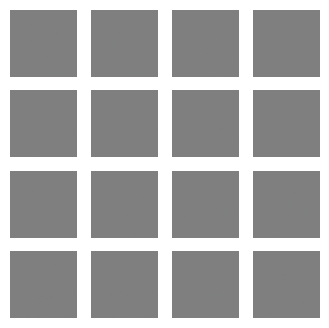

In [24]:
testNoise = tf.random.normal([BATCH_SIZE, LATENT_DIMENSION])
generateAndSaveImage(generator, 0, testNoise)

In [25]:
def trainModel(epochs, batch_size, noise_dimension, generator, discriminator, generator_optimizer, discriminator_optimizer, discriminator_loss, generator_loss, dataset):
    for epoch in range(epochs):
        start = time.time()  

        for image_batch in dataset:
            noise = tf.random.normal([batch_size, noise_dimension])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = generator(noise, training=True)

                real_output = discriminator(image_batch, training=True)
                fake_output = discriminator(generated_images, training=True)

                gen_loss = generator_loss(fake_output)

                disc_loss = discriminator_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}, Time: {time.time() - start} sec')
        
        generateAndSaveImage(generator, epoch + 1, noise)

       
        if epoch == epochs - 1:
            discriminator.save("discriminator_model.h5")
            generator.save("generator_model.h5")

Epoch 1, Generator Loss: 0.7566136121749878, Discriminator Loss: 1.6046333312988281, Time: 448.1534276008606 sec


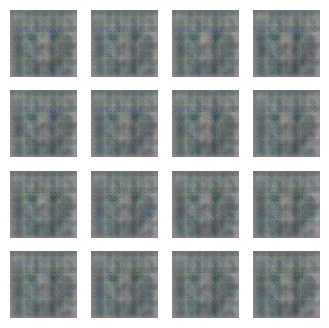

Epoch 2, Generator Loss: 0.9277203679084778, Discriminator Loss: 1.2525899410247803, Time: 425.49404525756836 sec


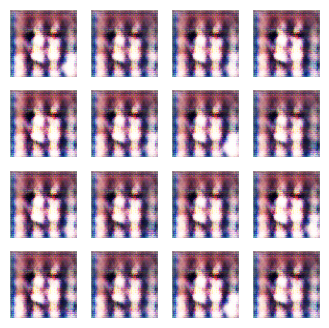

Epoch 3, Generator Loss: 1.3785853385925293, Discriminator Loss: 1.0799472332000732, Time: 985.6662631034851 sec


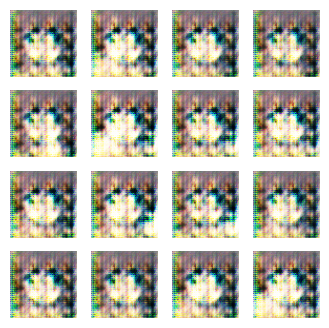

Epoch 4, Generator Loss: 1.1883013248443604, Discriminator Loss: 0.9520822763442993, Time: 252.35168957710266 sec


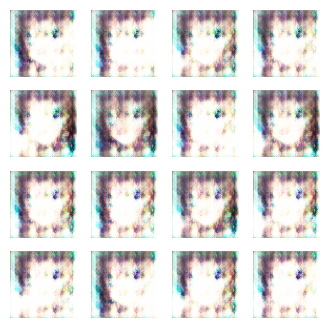

Epoch 5, Generator Loss: 2.139402389526367, Discriminator Loss: 1.2413487434387207, Time: 251.19500756263733 sec


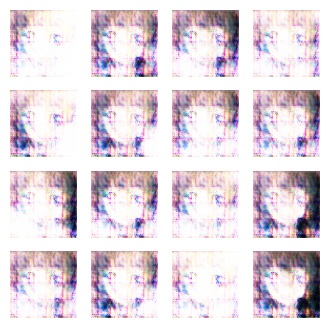

Epoch 6, Generator Loss: 1.2110522985458374, Discriminator Loss: 0.9617946743965149, Time: 254.9264853000641 sec


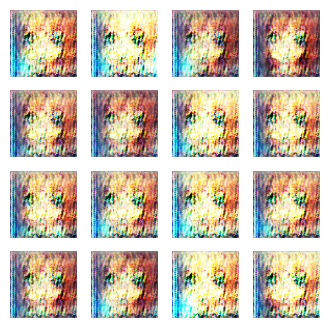

Epoch 7, Generator Loss: 1.0923645496368408, Discriminator Loss: 1.0670751333236694, Time: 258.4691939353943 sec


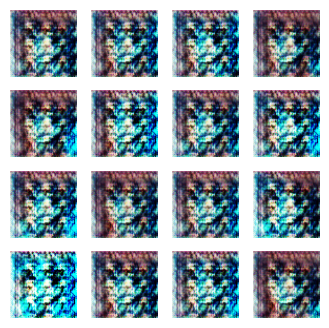

Epoch 8, Generator Loss: 1.4738320112228394, Discriminator Loss: 0.9005687832832336, Time: 1402.249696969986 sec


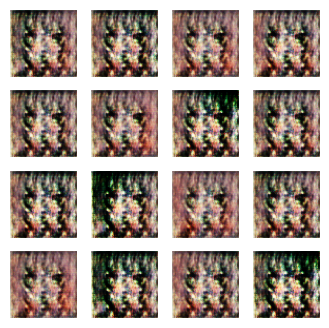

Epoch 9, Generator Loss: 1.745058536529541, Discriminator Loss: 0.9445491433143616, Time: 253.53508710861206 sec


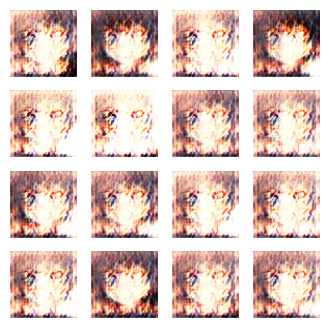

Epoch 10, Generator Loss: 1.583085060119629, Discriminator Loss: 0.7822813987731934, Time: 251.1892614364624 sec


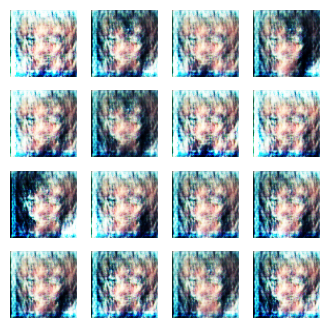

Epoch 11, Generator Loss: 1.043792963027954, Discriminator Loss: 1.1635226011276245, Time: 244.5092749595642 sec


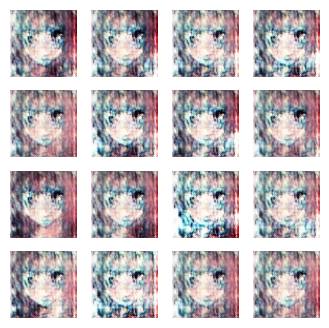

Epoch 12, Generator Loss: 2.1241984367370605, Discriminator Loss: 0.7613827586174011, Time: 244.40095806121826 sec


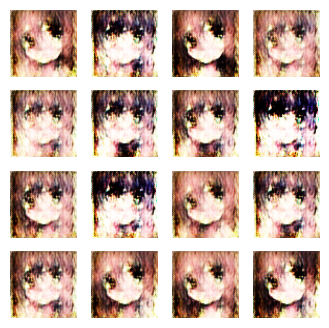

Epoch 13, Generator Loss: 1.9135355949401855, Discriminator Loss: 0.7974071502685547, Time: 244.59100127220154 sec


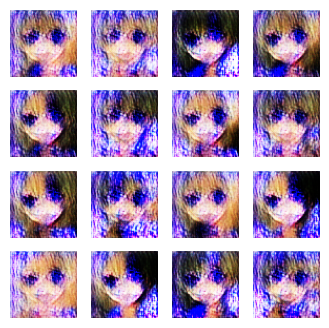

Epoch 14, Generator Loss: 1.8402974605560303, Discriminator Loss: 0.7620440721511841, Time: 248.91888332366943 sec


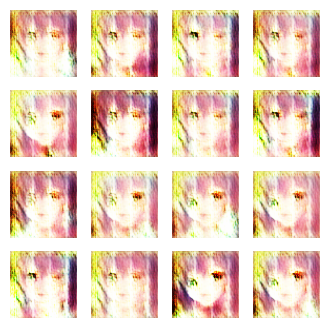

Epoch 15, Generator Loss: 1.452791452407837, Discriminator Loss: 0.7771288752555847, Time: 248.54788303375244 sec


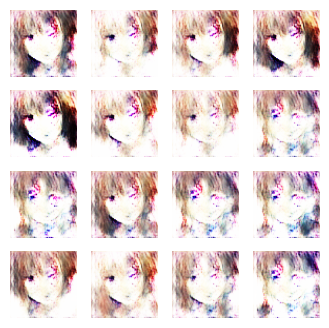

Epoch 16, Generator Loss: 3.029559373855591, Discriminator Loss: 1.039957880973816, Time: 252.80584454536438 sec


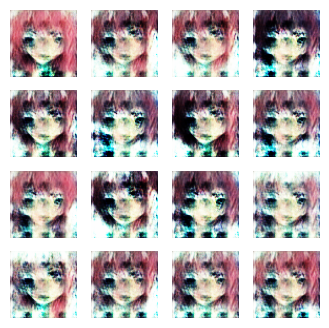

Epoch 17, Generator Loss: 1.9163365364074707, Discriminator Loss: 0.6980646848678589, Time: 253.18987941741943 sec


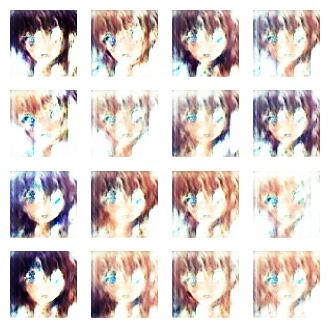

Epoch 18, Generator Loss: 1.3420530557632446, Discriminator Loss: 0.7703633308410645, Time: 253.5214455127716 sec


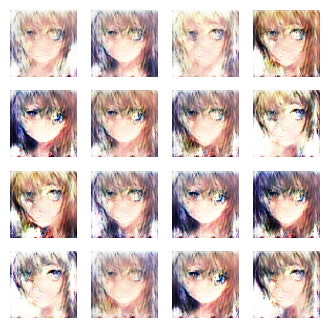

Epoch 19, Generator Loss: 2.0647358894348145, Discriminator Loss: 0.6813203692436218, Time: 254.23097205162048 sec


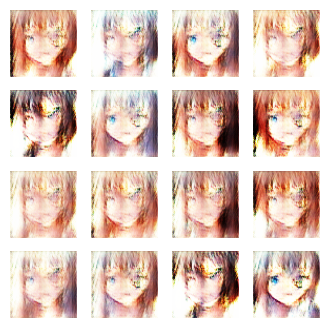

Epoch 20, Generator Loss: 2.6661853790283203, Discriminator Loss: 0.6034736633300781, Time: 253.80162048339844 sec


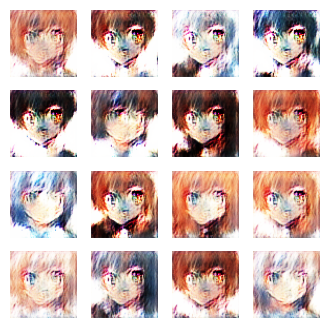

Epoch 21, Generator Loss: 2.2178852558135986, Discriminator Loss: 0.6584150791168213, Time: 253.24193239212036 sec


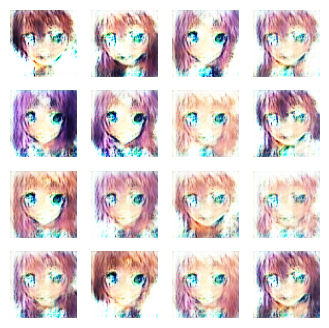

Epoch 22, Generator Loss: 2.7196645736694336, Discriminator Loss: 0.6634265184402466, Time: 253.33815097808838 sec


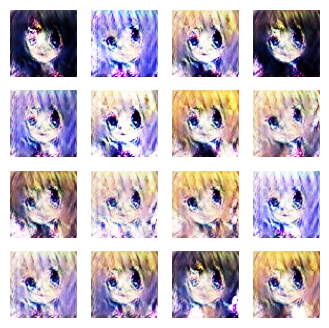

Epoch 23, Generator Loss: 2.7600505352020264, Discriminator Loss: 0.6068521738052368, Time: 255.06458854675293 sec


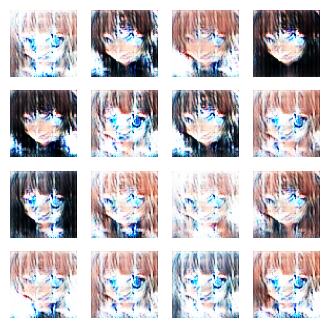

Epoch 24, Generator Loss: 0.8951072692871094, Discriminator Loss: 1.1456055641174316, Time: 253.08380150794983 sec


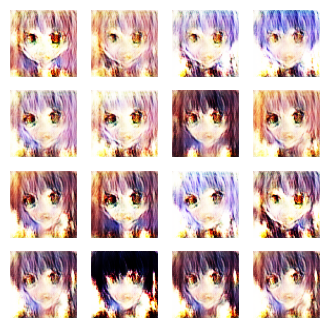

Epoch 25, Generator Loss: 2.5640082359313965, Discriminator Loss: 0.650214433670044, Time: 248.87596249580383 sec


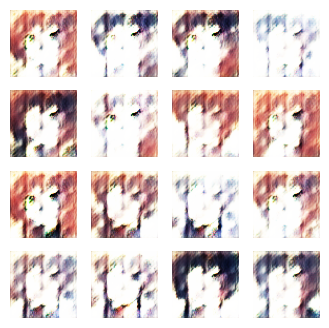

Epoch 26, Generator Loss: 1.8504118919372559, Discriminator Loss: 0.676058292388916, Time: 248.74408984184265 sec


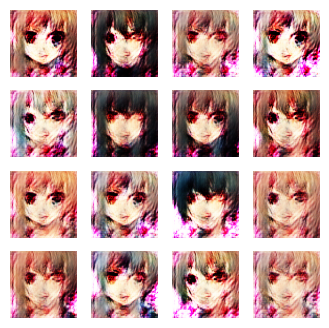

Epoch 27, Generator Loss: 2.6366329193115234, Discriminator Loss: 0.6559375524520874, Time: 248.02334117889404 sec


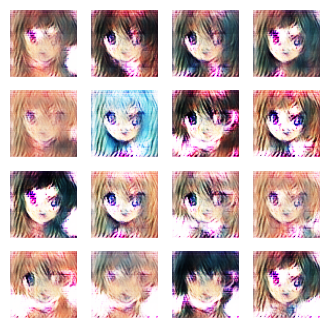

Epoch 28, Generator Loss: 2.9424009323120117, Discriminator Loss: 0.6121004819869995, Time: 247.63437294960022 sec


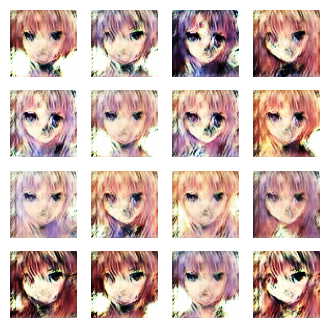

Epoch 29, Generator Loss: 3.474144458770752, Discriminator Loss: 0.6333925127983093, Time: 247.50117111206055 sec


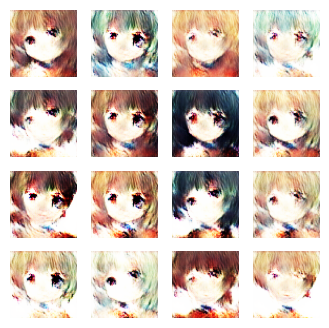

Epoch 30, Generator Loss: 2.7581892013549805, Discriminator Loss: 0.5518417358398438, Time: 247.9576075077057 sec


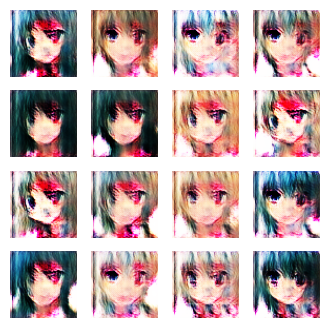

C:\Users\MONSTER\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:

trainModel(EPOCHS,
           BATCH_SIZE,
           LATENT_DIMENSION,
           generator,
           discriminator,
           generatorOptimizer,
           discriminatorOptimizer,
           discriminatorLoss,
           generatorLoss,
           dataset)